In [ ]:
#importing libraries
import time
import matplotlib.pyplot as plt
import random
import pandas as pd
import numpy as np
import seaborn as sns
import re
import tensorflow as tf
from tensorflow import keras
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding,LSTM,Dense,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import accuracy_score

In [ ]:
save = False #@param {type: "boolean"}

# Load the dataset for my drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/NFC
%ls

/content/drive/MyDrive/NFC
 news-classification.zip   project-3.ipynb      project.ipynb  'Αντίγραφο του project 666.ipynb'
 project-2.ipynb          'project 666.ipynb'   saves/


# Import the data.

In [ ]:
#importing the dataset
dir = pd.read_csv("news-classification.zip")
pd.set_option('display.max_columns', None)
dir.head()

,data_id,id,date,source,title,content,author,url,published,published_utc,collection_utc,category_level_1,category_level_2
0,1809,abcnews--2019-10-31--Virginia mom charged with...,2019-10-31,abcnews,Virginia mom charged with murder in 2-year-old...,The Virginia woman whose 2-year-old son was fo...,NaN,https://abcnews.go.com/US/wireStory/virginia-m...,"Thu, 31 Oct 2019 16:49:56 -0400",1572554996,1572559512,"crime, law and justice",crime
1,1980,abcnews--2019-11-07--2 escaped murder suspects...,2019-11-07,abcnews,2 escaped murder suspects arrested at US-Mexic...,Authorities are trying to determine if anyone ...,NaN,https://abcnews.go.com/US/wireStory/escaped-mu...,"Thu, 07 Nov 2019 00:13:12 -0500",1573103592,1573131986,"crime, law and justice",crime
2,1995,abcnews--2019-11-07--Family turns in escaped b...,2019-11-07,abcnews,"Family turns in escaped boy, 13, suspected in ...",A 13-year-old suspect in a double homicide who...,NaN,https://abcnews.go.com/US/wireStory/family-tur...,"Thu, 07 Nov 2019 07:39:54 -0500",1573130394,1573131982,"crime, law and justice",crime
3,2740,abcnews--2019-12-02--Mother charged with murde...,2019-12-02,abcnews,Mother charged with murder in deaths of 2 youn...,The mother of two young children found hanging...,NaN,https://abcnews.go.com/US/wireStory/mother-cha...,"Mon, 02 Dec 2019 11:30:59 -0500",1575304259,1575308811,"crime, law and justice",crime
4,7038,ageofautism--2019-04-12--Physician Father and ...,2019-04-12,ageofautism,"Physician, Father and Caretaker of 29 Year Old...","""One family member said Derek “can be violent ...",Age of Autism,http://feedproxy.google.com/~r/ageofautism/~3/...,2019-04-12 09:00:00+00:00,1555074000,1567543083,"crime, law and justice",crime


In [ ]:
#creating a new dataset with only relevant features.
ds = dir[['title','category_level_1','category_level_2']]
ds.head()

,title,category_level_1,category_level_2
0,Virginia mom charged with murder in 2-year-old...,"crime, law and justice",crime
1,2 escaped murder suspects arrested at US-Mexic...,"crime, law and justice",crime
2,"Family turns in escaped boy, 13, suspected in ...","crime, law and justice",crime
3,Mother charged with murder in deaths of 2 youn...,"crime, law and justice",crime
4,"Physician, Father and Caretaker of 29 Year Old...","crime, law and justice",crime


In [ ]:
#shuffling rows with the help of sample, here (frac = 1) means return all rows
ds = ds.sample(frac=1).reset_index(drop=True)
ds.head()

,title,category_level_1,category_level_2
0,WATCH Migrants Brawl After Quran-Throwing Prot...,religion and belief,religious text
1,The disease that kills by stealing sleep - fat...,health,diseases and conditions
2,Union boosts strike pay for GM workers as talk...,labour,unions
3,Ukraine creating new obstacles for exchange of...,"conflict, war and peace",prisoners of war
4,Best resistance bands: The best workout and ex...,lifestyle and leisure,exercise and fitness


In [ ]:
#checking for null values
ds.isnull().sum()

title               0
category_level_1    0
category_level_2    0
dtype: int64

<Axes: xlabel='category_level_1', ylabel='count'>

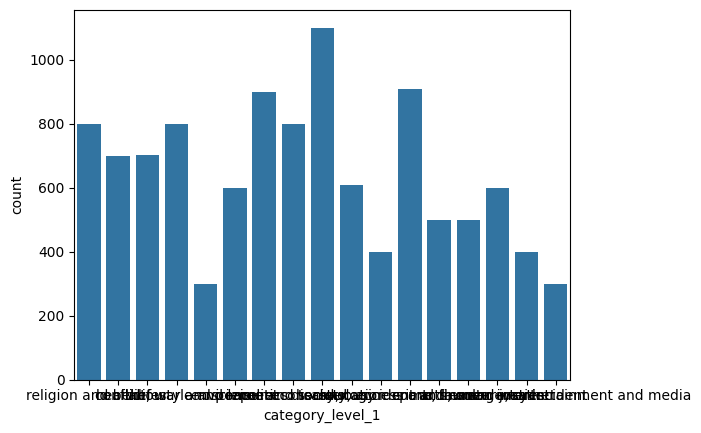

In [ ]:
#plotting graph for categories
sns.countplot(x = 'category_level_1',data = ds)

<Axes: xlabel='category_level_2', ylabel='count'>

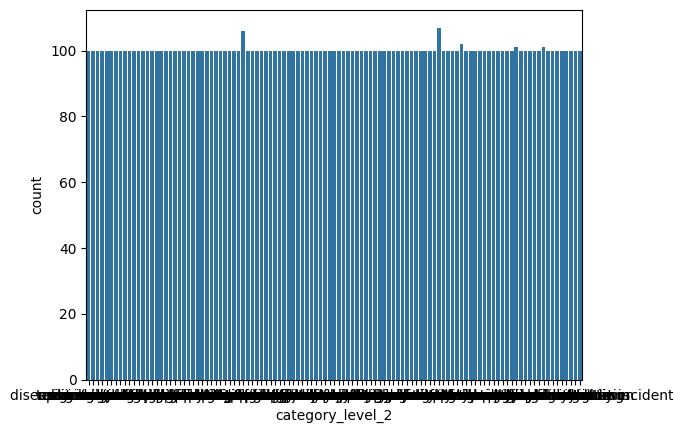

In [ ]:
#plotting graph for categories
sns.countplot(x = 'category_level_2',data = ds)

# Cleaning and preprocessing the text.

In [ ]:
#cleaning and preprocessing the text
import nltk
nltk.download('stopwords')
cleaned = []
for i in range(0,len(ds)):

    #removing any other words than (a-z) and (A-Z)
    msg = re.sub('[^a-zA-Z]',' ',ds['title'][i])
    if i < 5:
      print(msg)

    #converting all texts to lower case
    msg = msg.lower()

    #tokenizing
    msg = msg.split()

    #stemming and removing stopwords
    ps = PorterStemmer()
    msg = [ps.stem(words) for words in msg if not words in set(stopwords.words('english'))]
    msg = ' '.join(msg)
    cleaned.append(msg)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


WATCH Migrants Brawl After Quran Throwing Protests in Denmark
The disease that kills by stealing sleep   fatal familial insomnia
Union boosts strike pay for GM workers as talks continue
Ukraine creating new obstacles for exchange of prisoners   Lavrov
Best resistance bands  The best workout and exercise resistance bands


In [ ]:
#taking dictionary size 5000
dict_size = 5000


# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(cleaned)
sequences = tokenizer.texts_to_sequences(cleaned)

#now for input as an embedding layer length of all rows should be equal therefore applying padding
#this will make size of all rows equal by adding 0 at starting of the shorter rows
#size of each row will be equal to length of longest row.
embedded_layer = pad_sequences(sequences,padding = 'pre',maxlen = 150)

In [ ]:
#now creating independent and dependent features
x = embedded_layer
input_len = len(x[0])
label_1 = np.array(ds['category_level_1'])
label_2 = np.array(ds['category_level_2'])
label_1_n = np.unique(np.array(ds["category_level_1"]))
label_2_n = np.unique(np.array(ds["category_level_2"]))
label_1_v = len(label_1_n)
label_2_v = len(label_2_n)

In [ ]:
#converting categorical values of y using OneHotEncoding
label_encoder = LabelEncoder()
label_1 = label_encoder.fit_transform(label_1)
label_1 = to_categorical(label_1,label_1_v)

#converting categorical values of z using OneHotEncoding
label_encoder_2 = LabelEncoder()
label_2 = label_encoder_2.fit_transform(label_2)
label_2 = to_categorical(label_2,label_2_v)

In [ ]:
# splitting the Dataset into Train and Test set
x_train,x_test,y_train,y_test,z_train,z_test=train_test_split(x,label_1,label_2,test_size=0.2,random_state=42)

# Model for category_level_1.

## LSTM model.

In [ ]:
#creating model using LSTM
model = Sequential()

#taking number features as 50
model.add(Embedding(dict_size,50,input_length = input_len))
model.add(Dropout(0.2))

#adding LSTM layers with 8*label_1_v neurons
model.add(LSTM(8*label_1_v))

#adding output layer
model.add(Dense(label_1_v,activation="softmax"))

#compiling the model
model.compile(loss="categorical_crossentropy",optimizer='adam',metrics=["accuracy"])

#summary of model
model.summary()

#training the model
rnn = model.fit(x_train, y_train, validation_data = (x_test,y_test), epochs = 15, batch_size = 256)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 50)           250000    
                                                                 
 dropout (Dropout)           (None, 150, 50)           0         
                                                                 
 lstm (LSTM)                 (None, 136)               101728    
                                                                 
 dense (Dense)               (None, 17)                2329      
                                                                 
Total params: 354057 (1.35 MB)
Trainable params: 354057 (1.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/15
35/35 [==============================] - 10s 165ms/step - loss: 2.7829 - accuracy: 0.1000 - val_loss: 2.7441 - val_accuracy: 0.0966
Epoch 2/1

In [ ]:
#evaluating our model
model.evaluate(x_test,y_test)

69/69 [==============================] - 0s 6ms/step - loss: 0.9212 - accuracy: 0.7784


[0.9212058782577515, 0.778388261795044]

## MultinomialNB model

In [ ]:
# Extract LSTM features
lstm_features = model.predict(x)

# splitting the Dataset into Train and Test set
x2_train,x2_test,y2_train,y2_test=train_test_split(lstm_features,label_1,test_size=0.2,random_state=78)

342/342 [==============================] - 2s 4ms/step


In [ ]:
# Build a simple neural network for classification
model2 = Sequential()
model2.add(Dense(units=len(label_encoder.classes_), activation='softmax', input_dim=lstm_features.shape[1]))

# Compile the model
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model2.fit(x2_train, y2_train, epochs=15, batch_size=32, validation_split=0.2)

Epoch 1/15
219/219 [==============================] - 1s 3ms/step - loss: 2.6739 - accuracy: 0.2979 - val_loss: 2.5296 - val_accuracy: 0.4150
Epoch 2/15
219/219 [==============================] - 1s 3ms/step - loss: 2.3836 - accuracy: 0.5527 - val_loss: 2.2546 - val_accuracy: 0.7596
Epoch 3/15
219/219 [==============================] - 1s 3ms/step - loss: 2.1169 - accuracy: 0.8566 - val_loss: 2.0007 - val_accuracy: 0.8609
Epoch 4/15
219/219 [==============================] - 1s 3ms/step - loss: 1.8720 - accuracy: 0.8978 - val_loss: 1.7683 - val_accuracy: 0.8981
Epoch 5/15
219/219 [==============================] - 1s 3ms/step - loss: 1.6492 - accuracy: 0.9060 - val_loss: 1.5582 - val_accuracy: 0.9004
Epoch 6/15
219/219 [==============================] - 1s 3ms/step - loss: 1.4497 - accuracy: 0.9290 - val_loss: 1.3707 - val_accuracy: 0.9290
Epoch 7/15
219/219 [==============================] - 1s 3ms/step - loss: 1.2736 - accuracy: 0.9324 - val_loss: 1.2064 - val_accuracy: 0.9325
Epoch 

In [ ]:
# Evaluate the model on the test set
predictions = model2.predict(x2_test)
# Convert one-hot encoded predictions back to numerical labels
predictions_numerical = np.argmax(predictions, axis=1)
accuracy = accuracy_score(np.argmax(y2_test, axis=1), predictions_numerical)
print("Accuracy:", accuracy)

69/69 [==============================] - 0s 2ms/step
Accuracy: 0.9326923076923077


# Model for category_level_2.


## LSTM model.

In [ ]:
#creating model using LSTM
model3 = Sequential()

model3.add(Embedding(dict_size,100,input_length = input_len))
model3.add(Dropout(0.2))

#adding LSTM layers with 11*label_2_v neurons
model3.add(LSTM(11*label_2_v))

#adding output layer
model3.add(Dense(label_2_v,activation="softmax"))

#compiling the model
model3.compile(loss="categorical_crossentropy",optimizer='adam',metrics=["accuracy"])

#summary of model
model3.summary()

#training the model
rnn = model3.fit(x_train, z_train, validation_data = (x_test, z_test), epochs = 20, batch_size = 128)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 150, 100)          500000    
                                                                 
 dropout_1 (Dropout)         (None, 150, 100)          0         
                                                                 
 lstm_1 (LSTM)               (None, 1199)              6234800   
                                                                 
 dense_2 (Dense)             (None, 109)               130800    
                                                                 
Total params: 6865600 (26.19 MB)
Trainable params: 6865600 (26.19 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
69/69 [==============================] - 21s 275ms/step - loss: 4.6500 - accuracy: 0.0475 - val_loss: 4.4942 - val_accuracy: 0.0554
Epo

In [ ]:
#evaluating our model
result = model3.evaluate(x_test, z_test)
print(result)

69/69 [==============================] - 2s 32ms/step - loss: 2.6327 - accuracy: 0.5774
[2.632694959640503, 0.5773809552192688]


## MultinomialNB model

In [ ]:
# Extract LSTM features
lstm_features_2= model3.predict(x)

# splitting the Dataset into Train and Test set
x2_train,x2_test,z2_train,z2_test=train_test_split(lstm_features_2,label_2,test_size=0.2,random_state=78)

342/342 [==============================] - 11s 31ms/step


In [ ]:
# Build a simple neural network for classification
model4 = Sequential()
model4.add(Dense(units=label_2_v, activation='softmax', input_dim=lstm_features_2.shape[1]))

# Compile the model
model4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model4.summary()
# Train the model
model4.fit(x2_train, z2_train, epochs=15, batch_size=32, validation_split=0.2)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 109)               11990     
                                                                 
Total params: 11990 (46.84 KB)
Trainable params: 11990 (46.84 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/15
219/219 [==============================] - 2s 5ms/step - loss: 4.6060 - accuracy: 0.2501 - val_loss: 4.5140 - val_accuracy: 0.4608
Epoch 2/15
219/219 [==============================] - 1s 4ms/step - loss: 4.4267 - accuracy: 0.5847 - val_loss: 4.3417 - val_accuracy: 0.7230
Epoch 3/15
219/219 [==============================] - 1s 3ms/step - loss: 4.2489 - accuracy: 0.7870 - val_loss: 4.1713 - val_accuracy: 0.8306
Epoch 4/15
219/219 [==============================] - 1s 3ms/step - loss: 4.0731 - accuracy: 0.8547 - val_loss: 4.0025 -

In [ ]:
# Evaluate the model on the test set
predictions = model4.predict(x2_test)
# Convert one-hot encoded predictions back to numerical labels
predictions_numerical = np.argmax(predictions, axis=1)
accuracy = accuracy_score(np.argmax(z2_test, axis=1), predictions_numerical)
print("Accuracy:", accuracy)

69/69 [==============================] - 0s 1ms/step
Accuracy: 0.8763736263736264


# Save the model.

In [ ]:
if save:
  model.save('saves/model_1.keras')
  model.save('saves/model_1.h5')

  model2.save('saves/model_2.keras')
  model2.save('saves/model_2.h5')

  model3.save('saves/model_3.keras')
  model3.save('saves/model_3.h5')

  model4.save('saves/model_4.keras')
  model4.save('saves/model_4.h5')

  print("The models is save.")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


The models is save.
